<a href="https://colab.research.google.com/github/narayansharma275/RandomML/blob/main/ImageSegmentionUsingClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [363]:
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage
from sklearn.cluster import KMeans
from collections import Counter
import cv2
from PIL import Image


In [227]:
# Scaling the image pixels values within 0-1
img = imread('chair.jpeg') / 255


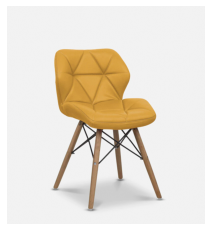

In [228]:
plt.imshow(img)
plt.axis('off')
# plt.title('Original')
plt.show()


In [229]:
#Reshape
image_2D = img.reshape(img.shape[0]*img.shape[1], img.shape[2])

In [259]:
#cluster creation
kmeans = KMeans(n_clusters=5, random_state=0)
labels = kmeans.fit_predict(image_2D)


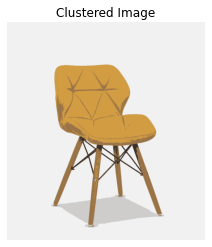

In [260]:

clustered = kmeans.cluster_centers_[labels]
clustered_3D = clustered.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(clustered_3D)
plt.title('Clustered Image')
plt.axis('off')
plt.show()

In [232]:
def RGB2HEX(color):
    color = color*255
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))


In [376]:
color_counts = Counter(labels)
print("color_counts",color_counts)
centroids = kmeans.cluster_centers_
centroidal_colors = [centroids[key] for key in color_counts.keys()]



rgb_colors = [centroidal_colors[i] for i in color_counts.keys()]
hex_colors = [RGB2HEX(centroidal_colors[i]) for i in color_counts.keys()]
hex_colors_with_clusterlabels = [(i,RGB2HEX(centroidal_colors[i])) for i in color_counts.keys()]


color_counts Counter({1: 550657, 2: 81900, 0: 36143, 3: 28738, 4: 6562})


([<matplotlib.patches.Wedge at 0x7fd843a4fed0>,
 [Text(-0.8523537666766186, 0.6953366497116203, "(1, '#cecdcc')"),
  Text(0.35692206233382484, -1.0404838496677251, "(3, '#9a7446')"),
  Text(0.8073881006142364, -0.747077275110504, "(2, '#d29c43')"),
  Text(1.0735223456444911, -0.23989533843313884, "(0, '#f1f1f1')"),
  Text(1.0995284150591307, -0.032206590591932274, "(4, '#382f29')")])

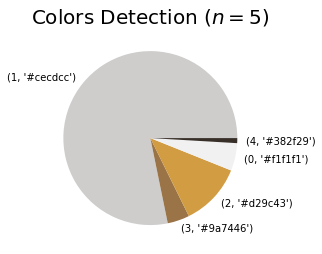

In [373]:
## Can automate this setting a range for hex colors and identifying the color of the 2nd most dominant color (assuming bg will be most dom)

plt.title('Colors Detection ($n=5$)', fontsize=20)
plt.pie(color_counts.values(), labels = hex_colors_with_clusterlabels, colors = hex_colors)  



In [352]:
# !pip install webcolors


In [341]:
from scipy.spatial import KDTree
from webcolors import CSS3_HEX_TO_NAMES, hex_to_rgb
name_to_hex = res = dict(zip(CSS3_HEX_TO_NAMES.values(), CSS3_HEX_TO_NAMES.keys())) #rev of hex to name


In [347]:
def rgb_to_english(rgb_tuple):
    
    css2_db = CSS3_HEX_TO_NAMES
    c_names = []
    rgb_values = []
    for hex_value, c_name in css2_db.items():
        c_names.append(c_name)
        rgb_values.append(hex_to_rgb(hex_value))
    
    kdt_db = KDTree(rgb_values)

    distance, index = kdt_db.query(rgb_tuple)
    return  c_names[index]

In [378]:
## Fetching color of any of the centroids, finding its nearest color name and then getting its rgb
from webcolors import name_to_rgb

closest_color = rgb_to_english(tuple(rgb_colors[2]*255))  # Multiply by 255 cuz we scaled the image down by 255
name_to_rgb(closest_color)   

IntegerRGB(red=205, green=133, blue=63)

In [263]:
## Extracting all the seat pixels of the chair which is cluster 2 & 3 for now
non_chair_seat_idx = [i for i,label in enumerate(labels) if (label !=2)]
len(non_chair_seat_idx)


622100

In [264]:
## selectin only those indices which have not been clustered 2 & 3 and assigning 0 there to create a mask
image2D_copy = image_2D.copy()
image2D_copy[non_chair_seat_idx] = image2D_copy[non_chair_seat_idx]*0

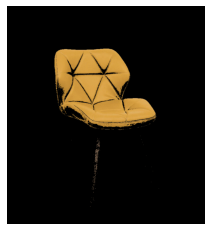

In [266]:
# plotting the image now
recons_only_seat = image2D_copy.reshape(img.shape)
plt.axis('off')
plt.imshow(recons_only_seat)

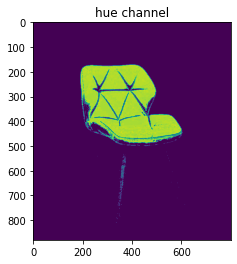

In [444]:
#changing color of the mask before merging it with the main image again

#all of the region at once but in the HSV space
im = Image.fromarray((recons_only_seat*255).astype(np.uint8))
onlyseat_hsv = cv2.cvtColor(np.float32(im), cv2.COLOR_RGB2HSV)

hue = onlyseat_hsv[:,:,0]  #Extracting hue channel

# plotting hue channel
plt.title('hue channel')
plt.imshow(hue)
plt.show()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


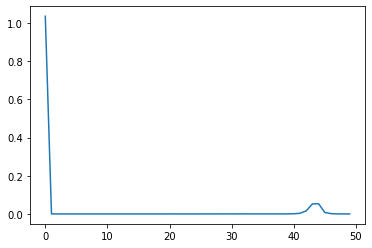

In [445]:
# check the hue intensity of seat 
hist, _ = np.histogram(hue, bins=50, normed=True)
plt.plot(hist)
plt.show()

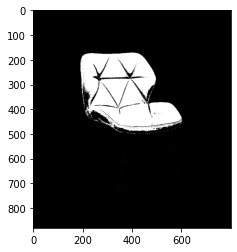

In [446]:
h =  43 # hue value
t = 10 # tolerance value

# creating a binary mask 
min_hue = np.array([h - t])
max_hue = np.array([h + t])

mask_hue = cv2.inRange(hue, min_hue, max_hue)

# visualise the mask
plt.imshow(mask_hue, cmap='gray')

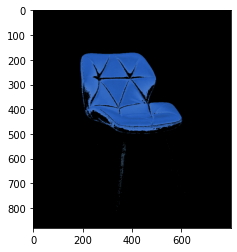

In [449]:
# modfiy value for non 0 pixels 
hue[mask_hue > 0] = hue[mask_hue > 0] + 120 # 120 because 43 + 120 = 160 which is purple/pink; wanted chaire to be purple/pink

# assign the modified hue channel back to the hsv image
onlyseat_hsv[:,:,0] = hue

im_final = cv2.cvtColor(onlyseat_hsv, cv2.COLOR_HSV2RGB)
plt.imshow((im_final * 255).astype(np.uint8))

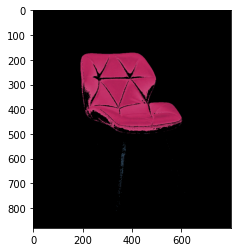

In [451]:
# modfiy value for non 0 pixels 
hue[mask_hue > 0] = hue[mask_hue > 0] + 120 # 120 because 43 + 120 = 160 which is purple/pink; wanted chaire to be purple/pink

# assign the modified hue channel back to the hsv image
onlyseat_hsv[:,:,0] = hue

im_final = cv2.cvtColor(onlyseat_hsv, cv2.COLOR_HSV2RGB)
plt.imshow((im_final * 255).astype(np.uint8))

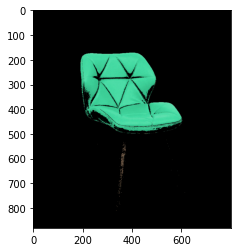

In [465]:
# modfiy value for non 0 pixels 
hue[mask_hue > 0] = hue[mask_hue > 0] + 120 # 120 because 43 + 120 = 160 which is purple/pink; wanted chaire to be purple/pink

# assign the modified hue channel back to the hsv image
onlyseat_hsv[:,:,0] = hue

im_final = cv2.cvtColor(onlyseat_hsv, cv2.COLOR_HSV2RGB)/255
plt.imshow((im_final))

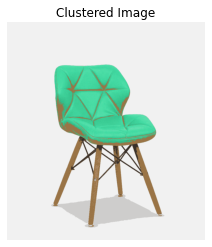

In [466]:
im_final_flat = im_final.reshape(im_final.shape[0]*im_final.shape[1], im_final.shape[2])
clustered[np.where(im_final_flat!=0)] =  im_final_flat[np.where(im_final_flat!=0)]

clustered_3D_new = clustered.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(clustered_3D_new)
plt.title('Clustered Image')
plt.axis('off')
plt.show()